In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from keras.layers import TextVectorization, Input, Embedding, concatenate, Conv1D, GlobalMaxPooling1D, RepeatVector, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
tf.keras.utils.set_random_seed(123)

Mounted at /content/drive


In [ ]:
trainDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/transformed_train.csv")
trainDF = trainDF[ trainDF["sentiment"] != -1 ]

testDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/transformed_test.csv")
testDF = testDF[ testDF["sentiment"] != -1 ]

In [ ]:
# Positve
trainDF[ trainDF["sentiment"] == 1 ].head(5)

,id,rating,sentiment,comment,posTag
1,1175,9,1,match|1|tag|team|table|match|bubba|ray|and|spi...,VERB|NUM|NOUN|NOUN|NOUN|NOUN|NOUN|NOUN|CCONJ|N...
2,4383,9,1,attention|spoiler|first|let|say|rob|roy|one|go...,NOUN|NOUN|ADV|VERB|VERB|VERB|NOUN|NUM|ADJ|NOUN...
3,10044,9,1,titanic|direct|james|cameron|present|fictional...,ADV|VERB|NOUN|NOUN|NOUN|ADJ|NOUN|NOUN|ADJ|NOUN...
4,4076,10,1,probably|hear|bit|new|disney|dub|miyazaki|clas...,ADV|VERB|NOUN|ADJ|NOUN|NOUN|NOUN|NOUN|NOUN|NOU...
5,2662,10,1,spoiler|begin|let|say|advantage|see|movie|big|...,NOUN|VERB|VERB|VERB|SCONJ|VERB|NOUN|ADJ|NOUN|C...


In [ ]:
# Negative
trainDF[ trainDF["sentiment"] == 0 ].head(5)

,id,rating,sentiment,comment,posTag
8,1930,4,0,some|praise|_atlantis|_the_lost_empire_|as|dis...,DET|VERB|NOUN|NOUN|ADP|PROPN|PROPN|NOUN|VERB|V...
9,1929,4,0,some|praise|atlantis|lose|empire|as|disney|adv...,DET|VERB|NOUN|VERB|NOUN|ADP|PROPN|PROPN|NOUN|V...
15,7726,1,0,warn|review|contain|plot|spoiler|though|nothin...,VERB|NOUN|NOUN|NOUN|NOUN|SCONJ|PRON|AUX|VERB|N...
16,2981,1,0,movie|recently|release|dvd|we|and|finally|get|...,NOUN|ADV|VERB|ADP|PRON|CCONJ|ADV|VERB|NOUN|VER...
21,1048,4,0,raise|victor|vargas|reviewyou|know|raise|victo...,VERB|NOUN|NOUN|NOUN|VERB|VERB|NOUN|NOUN|SCONJ|...


In [ ]:
vectorize_text = TextVectorization(
    standardize = None,
    output_mode = 'int',
    # output_sequence_length = 1000,
    # max_tokens = 40000,
    split = lambda text : tf.strings.split(text, sep = '|')
    )

vectorize_text.adapt(trainDF["comment"])

vectorize_pos = TextVectorization(
    standardize = None,
    output_mode = 'int',
    output_sequence_length = 1000,
    split = lambda text : tf.strings.split(text, sep = '|')
    ) 

vectorize_pos.adapt(trainDF["posTag"])

In [ ]:
X_text = vectorize_text(trainDF["comment"]).numpy()
X_pos  = vectorize_pos(trainDF["posTag"]).numpy()
Y_train = trainDF["sentiment"].to_numpy()

X_text_test = vectorize_text(testDF["comment"]).numpy()
X_pos_test = vectorize_text(testDF["posTag"]).numpy()
Y_test = testDF["sentiment"].to_numpy()

X_text_train, X_text_validation, X_pos_train, X_pos_validation, y_train, y_validation = train_test_split(X_text, X_pos, Y_train, test_size=0.1, random_state = 123)

In [ ]:
# Vectorized Comment Text
print("Vectorized Comment Text: {}".format(X_text.shape) )
print(X_text)
# Vectorized Part Of Speech
print("Vectorized Part Of Speech: {}".format(X_pos.shape) )
print(X_pos)

Vectorized Comment Text: (25000, 1612)
[[  673   239  2976 ...  1686    48  8099]
 [  588   552    45 ...     0     0     0]
 [ 2250   223   498 ...     0     0     0]
 ...
 [ 6892 10274    71 ...     0     0     0]
 [  503   442     8 ...     0     0     0]
 [    3   340     6 ...     0     0     0]]
Vectorized Part Of Speech: (25000, 1000)
[[ 3  8  2 ...  7  2  6]
 [ 2  2  5 ...  4  2  2]
 [ 5  3  2 ...  2  5  4]
 ...
 [ 3  2  4 ...  0  0  0]
 [10  3  8 ...  0  0  0]
 [ 3  4  6 ...  0  0  0]]


In [ ]:
sequence_length = np.array( [ np.trim_zeros(each, 'b').shape[0] for each in X_text ] )
sequence_length

array([1612, 1069, 1070, ...,    8,    7,    6])

(0.0, 1000.0)

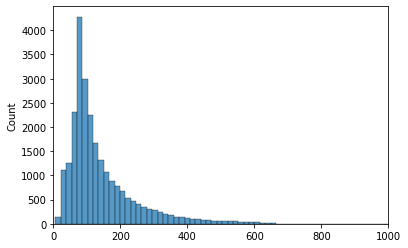

In [ ]:
sns.histplot(data = sequence_length, bins = 100)
# plt.ylim(0, 200)
plt.xlim(0, 1000)

In [ ]:
vocab = vectorize_text.get_vocabulary()
words = np.array( [ str(vocab[index]) for each in X_text for index in each if index > 1 ] )
wordsDF = pd.DataFrame(words, columns=['words'])
countDF = wordsDF.value_counts().to_frame("count")
countDF = countDF.reset_index().set_index("words")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


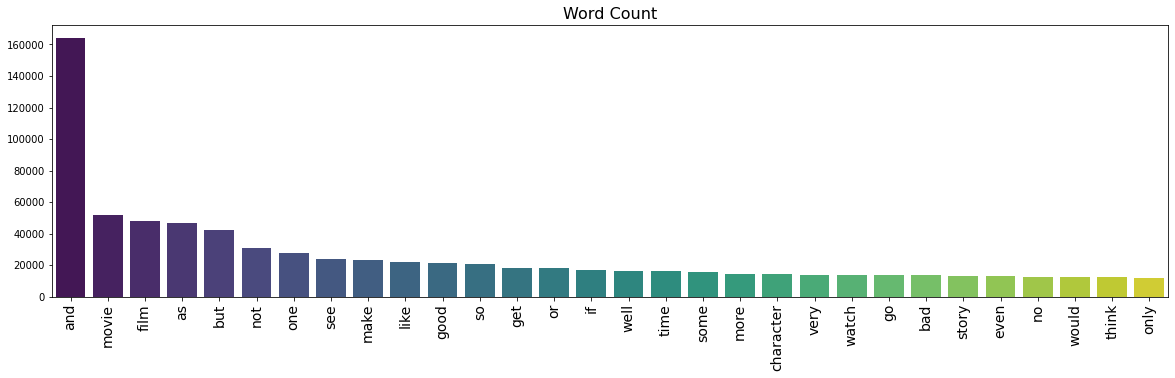

In [ ]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='viridis', ax=ax )

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

ax = word_frequency_barplot(countDF, 30)
ax.set_title("Word Count", fontsize=16);

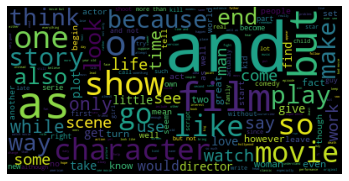

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

comment = ' '.join(trainDF["comment"])
wordcloud2 = WordCloud(stopwords={"ZZZZ"}).generate(comment)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

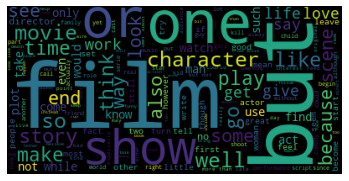

In [ ]:
comment = ' '.join(trainDF["comment"])
stopsWord = { "i","me","my","myself",
 "we","our","ours","ourselves",
 "you","you're","you've","you'll","you'd","your","yours","yourself","yourselves",
 "he","him","his","himself",
 "she","she's","her","hers","herself",
 "it","it's","its","itself",
 "they","them","their","theirs","themselves",
 "what","which","who","whom",
 "this","that","that'll","these","those",
 "am","is","are","was","were","be","been","being",
 "have","has","had","having",
 "do","does","did","doing",
 "a","an","the", "and", "as", "As", " as", "as ", " as "
 "of","at","by","for","with",
 "about","against","between","into","through","during",
 "before","after",
 "above","below",
 "to","from","up","down","in","out","on","off","over","under",
 "again","further","then","once","here","there",
 "when","where","why","how","all","any","both","each",
 "s","t",
 "can","will","just",
 "should","should've",
 "now","d","ll","m","o","re","ve","y","ma"}
wordcloud2 = WordCloud(stopwords=stopsWord).generate(comment)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

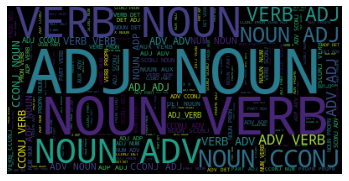

In [ ]:
posTag = ' '.join(trainDF["posTag"])
wordcloud2 = WordCloud(stopwords={"ZZZZ"}).generate(posTag)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()